In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from statsmodels.sandbox.stats.runs import runstest_1samp
from statsmodels.tsa.stattools import adfuller

### Data load

In [2]:
try:
    data = pd.read_csv("data/processed/NASDAQ_FULL_2021_Cleaned_Imputed.csv")
    print(f"Data loaded successfully with {data.shape[0]} rows (days) and {data.shape[1]} assets.")
except FileNotFoundError:
    print("Error: file NASDAQ_FULL_2021_Cleaned_Imputed.csv not found.")

Data loaded successfully with 252 rows (days) and 6540 assets.


In [3]:
eps = 1e-4

# np.log(P_t / P_{t-1}).
log_returns = np.log((data / data.shift(1)) + eps)

# Drop the first row which contains NaN values (as there is no P_{t-1} for the first day)
log_returns = log_returns.dropna(how="all")

print(f"Logarithmic returns calculated. Number of observations: {log_returns.shape[0]}.")

Logarithmic returns calculated. Number of observations: 251.


### Test on normal distribution

In [22]:
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm

def test_normality(r, name="TICKER"):
    r = r.dropna()
    print("===", name, "n=", len(r), "mean=", r.mean(), "std=", r.std())
    # Histogram + KDE + Normal pdf
    fig, ax = plt.subplots(1,2, figsize=(12,4))
    sns.histplot(r, kde=True, stat='density', ax=ax[0])
    xs = np.linspace(r.min(), r.max(), 200)
    ax[0].plot(xs, stats.norm.pdf(xs, r.mean(), r.std()), label='Normal fit')
    ax[0].legend()

    # Q-Q plot
    sm.qqplot(r, line='s', ax=ax[1])
    ax[1].set_title(f"QQ {name}")
    plt.show()

    # Tests
    jb_stat, jb_p = stats.jarque_bera(r)
    sh_stat, sh_p = stats.shapiro(r)
    ad_res = stats.anderson(r, dist='norm')
    ks_stat, ks_p = stats.kstest((r - r.mean())/r.std(), 'norm')
    print("Jarque-Bera:", jb_stat, jb_p)
    print("Shapiro-Wilk:", sh_stat, sh_p)
    print("KS (std sample vs N(0,1)):", ks_stat, ks_p)

Для анализа выберем 4 компании:
1) Apple Inc. (AAPL). Производственный сектор: Information Technology
2) Coca-Cola Europacific Partners PLC (CCEP) Производственный сектор: Consumer Staples
3) Tesla, Inc. (TSLA) Производственный сектор: Consumer Discretionary
4) Biogen Inc. (BIIB) Производственный сектор: Health Care

=== AAPL n= 251 mean= 0.0013848389582081864 std= 0.015749152378848053


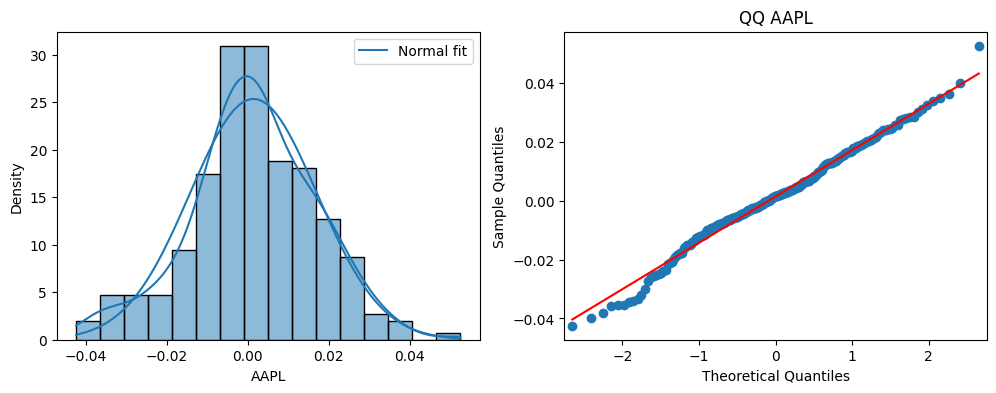

Jarque-Bera: 2.115819093004171 0.3471808176236278
Shapiro-Wilk: 0.9910913081312065 0.13037136862720605
KS (std sample vs N(0,1)): 0.05444394753257081 0.43123273761761993


In [5]:
test_normality(log_returns['AAPL'], 'AAPL')

1) Jarque-Bera: p > 0.05 -> нет значимых отклонений от нормальности
2) Shapiro-Wilk: p > 0.05 -> нормальность не отвергается
3) Kolmogorov–Smirnov (KS-test): p > 0.05 -> нормальность не отвергается

  Отсюда делаем вывод, что для доходность акций компании AAPL подчиняется нормальному закону

=== CCEP n= 251 mean= 0.0007939548002267296 std= 0.016674939054910923


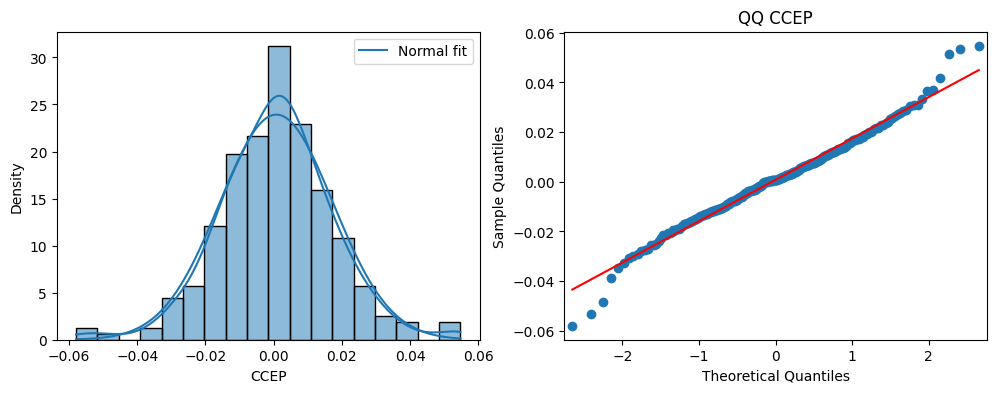

Jarque-Bera: 16.049968932096945 0.0003271851085465335
Shapiro-Wilk: 0.9860427308734154 0.015025123391040812
KS (std sample vs N(0,1)): 0.03945942158755672 0.8144029420605642


In [6]:
test_normality(log_returns['CCEP'], 'CCEP')

1) Jarque-Bera: p < 0.05 -> гипотеза о нормальности отвергается
2) Shapiro-Wilk: p < 0.05 -> гипотеза о нормальности отвергается
3) Kolmogorov–Smirnov (KS-test): p > 0.05 -> нормальность не отвергается

  Отсюда делаем вывод, что для доходность акций компании CCEP не подчиняется нормальному закону

=== TSLA n= 251 mean= 0.0015750147124171643 std= 0.03415696172144503


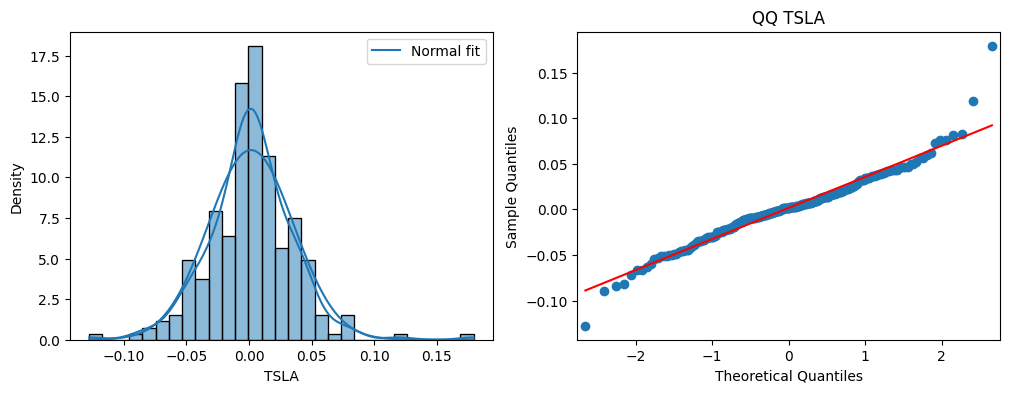

Jarque-Bera: 129.32902402021804 8.252000755134749e-29
Shapiro-Wilk: 0.9618047152295086 3.2092599999028086e-06
KS (std sample vs N(0,1)): 0.07499787349967146 0.11284823045028103


In [7]:
test_normality(log_returns['TSLA'], 'TSLA')

1) Jarque-Bera: p < 0.05 -> гипотеза о нормальности отвергается
2) Shapiro-Wilk: p < 0.05 -> гипотеза о нормальности отвергается
3) Kolmogorov–Smirnov (KS-test): p < 0.05 -> гипотеза о нормальности отвергается

  Отсюда делаем вывод, что для доходность акций компании TSLA не подчиняется нормальному закону

=== BIIB n= 251 mean= 5.003707044565762e-05 std= 0.02820482859142472


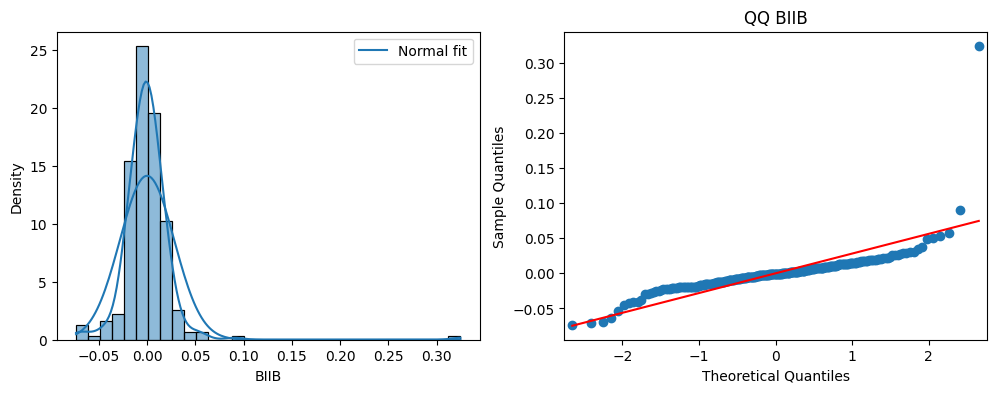

Jarque-Bera: 51193.43610588213 0.0
Shapiro-Wilk: 0.6220116341720445 3.5627470367868284e-23
KS (std sample vs N(0,1)): 0.15361977611012556 1.2262200961043202e-05


In [8]:
test_normality(log_returns['BIIB'], 'BIIB')

1) Jarque-Bera: p < 0.05 -> гипотеза о нормальности отвергается
2) Shapiro-Wilk: p < 0.05 -> гипотеза о нормальности отвергается
3) Kolmogorov–Smirnov (KS-test): p < 0.05 -> гипотеза о нормальности отвергается

  Отсюда делаем вывод, что для доходность акций компании BIIB не подчиняется нормальному закону

Доходности всех активов, кроме AAPL не подчиняются нормальному закону. Поэтому для них проверим другие распределения

### Other distributions

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

def fit_distributions(r, name="TICKER"):
    """
    Параметры:
        r : pandas.Series или numpy.array
        name : название актива
    """
    r = r.dropna().values
    n = len(r)
    
    distributions = {
        "Normal": stats.norm,
        "StudentT": stats.t,
        "Laplace": stats.laplace,
        "Logistic": stats.logistic,
        "GED": stats.gennorm
    }
    
    results = []
    
    for dist_name, dist in distributions.items():
        params = dist.fit(r)
        logL = np.sum(dist.logpdf(r, *params))
        k = len(params)
        
        AIC = 2*k - 2*logL
        BIC = k*np.log(n) - 2*logL
        
        cdf = lambda x: dist.cdf(x, *params)
        ks_stat, ks_p = stats.kstest(r, cdf)
        
        results.append({
            "Distribution": dist_name,
            "LogL": logL,
            "AIC": AIC,
            "BIC": BIC,
            "KS_p": ks_p,
            "Params": params
        })
        
    df_res = pd.DataFrame(results)
    df_res = df_res.sort_values(by="AIC").reset_index(drop=True)
    
    best = df_res.iloc[0]
    print(f"Best fit by AIC: {best['Distribution']}, AIC={best['AIC']:.2f}, KS p-value={best['KS_p']:.3f}")
    return df_res

In [19]:
fit_distributions(log_returns["CCEP"], name="CCEP")

Best fit by AIC: Logistic, AIC=-1349.61, KS p-value=0.884


,Distribution,LogL,AIC,BIC,KS_p,Params
0,Logistic,676.803495,-1349.606990,-1342.556084,0.884357,"(0.0007697146259237181, 0.009100997243813037)"
1,GED,676.906267,-1347.812535,-1337.236176,0.966989,"(1.3486800602761975, 0.0008348451469548626, 0...."
2,StudentT,676.779440,-1347.558880,-1336.982521,0.886725,"(6.402666465296001, 0.0007677197758722276, 0.0..."
3,Laplace,674.256446,-1344.512893,-1337.461987,0.680195,"(0.000786169902833556, 0.012532527142470714)"
4,Normal,671.903361,-1339.806721,-1332.755816,0.815643,"(0.0007939548002267296, 0.01664168889409971)"


In [20]:
fit_distributions(log_returns["TSLA"], name="TSLA")

Best fit by AIC: Laplace, AIC=-1007.90, KS p-value=0.964


,Distribution,LogL,AIC,BIC,KS_p,Params
0,Laplace,505.950708,-1007.901415,-1000.850509,0.963580,"(0.001868567181598163, 0.02450478065735718)"
1,GED,506.112956,-1006.225912,-995.649553,0.989259,"(1.0735493870465231, 0.0018549645498029611, 0...."
2,StudentT,504.647690,-1003.295380,-992.719021,0.768460,"(4.467061347957104, 0.0014966611675036408, 0.0..."
3,Logistic,503.129486,-1002.258972,-995.208066,0.519765,"(0.001473908745235562, 0.018015762200203997)"
4,Normal,491.921430,-979.842860,-972.791954,0.115377,"(0.0015750147124171643, 0.03408885205901564)"


In [21]:
fit_distributions(log_returns["BIIB"], name="BIIB")

Best fit by AIC: StudentT, AIC=-1284.44, KS p-value=0.964


,Distribution,LogL,AIC,BIC,KS_p,Params
0,StudentT,645.220855,-1284.441710,-1273.865351,0.963837,"(2.781652198658719, -0.0009832320026410043, 0...."
1,GED,637.173928,-1268.347856,-1257.771497,0.793530,"(0.7661471061197971, -0.0007399014063206518, 0..."
2,Laplace,632.575523,-1261.151045,-1254.100140,0.616104,"(-0.001033288430629131, 0.014796444158588185)"
3,Logistic,621.550999,-1239.101998,-1232.051092,0.561155,"(-0.0009615585408567003, 0.010800902433080526)"
4,Normal,539.981211,-1075.962422,-1068.911516,0.000013,"(5.003707044565762e-05, 0.028148587601084102)"
